In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from scipy.spatial.distance import cdist
from scipy.stats import zscore
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# even and odd
SPLITS = [
    [str(i) for i in range(1, 23) if i % 2 == 1] + ["X"],
    [str(i) for i in range(1, 23) if i % 2 == 0] + ["Y"],
]

# each chrom held out separately
#CHROMS = [str(i) for i in range(1, 23)]
#SPLITS = [[c for c in CHROMS if c != chrom] for chrom in CHROMS]

cols = ["chrom", "pos", "ref", "alt"]
dataset_path = "results/gwas/matched"

In [3]:
models = [
    "CADD.RawScore",
    "phyloP",
    "phastCons",
    "phyloP-Zoonomia",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species",
    "LongSafari/hyenadna-large-1m-seqlen-hf",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
    
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression",
    "Enformer.LogisticRegression",
    "LongSafari/hyenadna-large-1m-seqlen-hf.LogisticRegression",
]

embedding_models = [
    "Enformer",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species",
    "LongSafari/hyenadna-large-1m-seqlen-hf",
    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    "phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT",
    "LongSafari/hyenadna-large-1m-seqlen-hf": "HyenaDNA",
    
    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA-256",
}

V = pd.read_parquet(f"../../{dataset_path}/test.parquet")
d = Path(f"../../results/preds/{dataset_path}")
for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,pip,maf,label,CADD,phyloP-100-vertebrates,phastCons-100-vertebrates,phyloP-241-mammals,NT,HyenaDNA,GPN-MSA,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression,Enformer.LogisticRegression,LongSafari/hyenadna-large-1m-seqlen-hf.LogisticRegression
0,1,2293397,G,A,0.999863,0.370771,True,0.171697,1.126,-0.000,0.992,1.531799,1.966953e-06,-0.229947,-0.537581,-0.631052,-0.371038,-0.945803
1,1,3080038,T,C,0.999997,0.232951,True,0.929524,3.572,-0.000,2.697,-1.817169,2.384186e-07,-0.265800,-0.793795,-0.715999,-0.589731,-0.493970
2,1,3473193,A,G,1.000000,0.004888,True,-3.866422,-7.004,-1.000,-5.834,-0.192337,4.172325e-07,-7.358945,NaN,NaN,NaN,NaN
3,1,3774964,A,G,0.999972,0.230889,True,0.134059,3.552,-0.000,0.078,0.810181,4.768372e-07,0.366593,-0.656984,-0.839722,-0.812059,-0.681361
4,1,7734229,A,G,0.955835,0.354394,True,0.054014,0.921,-0.000,0.796,3.585876,3.039837e-06,0.051364,-0.450594,-0.664523,-0.357698,-0.486369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4593,9,131990428,A,T,0.008844,0.319611,False,0.148687,0.156,-0.000,1.983,-0.312408,-5.960464e-07,-1.423862,-0.462438,-0.455294,-0.346404,-0.482622
4594,9,80418212,A,T,0.001858,0.131431,False,-0.034983,0.885,-0.007,0.389,5.012543,4.410744e-06,0.327549,-0.233052,-0.117528,-0.317332,-0.302183
4595,9,137457837,C,A,0.002396,0.000404,False,-2.397935,-0.639,-0.999,-2.805,-3.509308,-4.827976e-06,-9.272251,NaN,NaN,NaN,NaN
4596,9,4258802,C,G,0.003577,0.165471,False,-0.648389,-0.724,-0.670,-0.517,0.074646,1.072884e-06,-4.683803,-0.460323,-0.352212,-0.363074,-0.440885


In [4]:
V["match_group"] = np.concatenate([np.arange(len(V)//2), np.arange(len(V)//2)])
V

,chrom,pos,ref,alt,pip,maf,label,CADD,phyloP-100-vertebrates,phastCons-100-vertebrates,phyloP-241-mammals,NT,HyenaDNA,GPN-MSA,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression,Enformer.LogisticRegression,LongSafari/hyenadna-large-1m-seqlen-hf.LogisticRegression,match_group
0,1,2293397,G,A,0.999863,0.370771,True,0.171697,1.126,-0.000,0.992,1.531799,1.966953e-06,-0.229947,-0.537581,-0.631052,-0.371038,-0.945803,0
1,1,3080038,T,C,0.999997,0.232951,True,0.929524,3.572,-0.000,2.697,-1.817169,2.384186e-07,-0.265800,-0.793795,-0.715999,-0.589731,-0.493970,1
2,1,3473193,A,G,1.000000,0.004888,True,-3.866422,-7.004,-1.000,-5.834,-0.192337,4.172325e-07,-7.358945,NaN,NaN,NaN,NaN,2
3,1,3774964,A,G,0.999972,0.230889,True,0.134059,3.552,-0.000,0.078,0.810181,4.768372e-07,0.366593,-0.656984,-0.839722,-0.812059,-0.681361,3
4,1,7734229,A,G,0.955835,0.354394,True,0.054014,0.921,-0.000,0.796,3.585876,3.039837e-06,0.051364,-0.450594,-0.664523,-0.357698,-0.486369,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4593,9,131990428,A,T,0.008844,0.319611,False,0.148687,0.156,-0.000,1.983,-0.312408,-5.960464e-07,-1.423862,-0.462438,-0.455294,-0.346404,-0.482622,2294
4594,9,80418212,A,T,0.001858,0.131431,False,-0.034983,0.885,-0.007,0.389,5.012543,4.410744e-06,0.327549,-0.233052,-0.117528,-0.317332,-0.302183,2295
4595,9,137457837,C,A,0.002396,0.000404,False,-2.397935,-0.639,-0.999,-2.805,-3.509308,-4.827976e-06,-9.272251,NaN,NaN,NaN,NaN,2296
4596,9,4258802,C,G,0.003577,0.165471,False,-0.648389,-0.724,-0.670,-0.517,0.074646,1.072884e-06,-4.683803,-0.460323,-0.352212,-0.363074,-0.440885,2297


In [5]:
features = {}

for m in embedding_models:
    df = pd.read_parquet(f"../../results/preds/vep_embedding/{dataset_path}/{m}.parquet")
    df.columns = model_renaming.get(m, m) + "_" + df.columns
    if m == "Enformer": df = -df.abs()
    features[model_renaming.get(m, m)] = df.columns.values
    V = pd.concat([V, df], axis=1)
embedding_models = [model_renaming.get(m, m) for m in embedding_models]
V

,chrom,pos,ref,alt,pip,maf,label,CADD,phyloP-100-vertebrates,phastCons-100-vertebrates,...,GPN-MSA-256_embedding_758,GPN-MSA-256_embedding_759,GPN-MSA-256_embedding_760,GPN-MSA-256_embedding_761,GPN-MSA-256_embedding_762,GPN-MSA-256_embedding_763,GPN-MSA-256_embedding_764,GPN-MSA-256_embedding_765,GPN-MSA-256_embedding_766,GPN-MSA-256_embedding_767
0,1,2293397,G,A,0.999863,0.370771,True,0.171697,1.126,-0.000,...,132.448151,229.079071,187.054932,225.620209,138.645233,78.386307,233.913345,433.739044,215.475616,132.263245
1,1,3080038,T,C,0.999997,0.232951,True,0.929524,3.572,-0.000,...,133.606796,207.323364,137.662384,116.889969,107.396698,146.264374,300.990356,415.908264,177.215790,269.483582
2,1,3473193,A,G,1.000000,0.004888,True,-3.866422,-7.004,-1.000,...,177.493286,154.903137,206.770905,250.443298,233.482315,191.948273,431.032532,358.996429,445.046936,280.838593
3,1,3774964,A,G,0.999972,0.230889,True,0.134059,3.552,-0.000,...,112.657539,231.917084,145.642853,161.557648,72.399300,91.998825,323.105835,452.138397,176.741455,277.894165
4,1,7734229,A,G,0.955835,0.354394,True,0.054014,0.921,-0.000,...,157.113388,161.096237,116.854958,159.173187,87.546524,122.363190,297.040131,425.684204,166.669830,212.188477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4593,9,131990428,A,T,0.008844,0.319611,False,0.148687,0.156,-0.000,...,207.399811,164.301407,127.185989,125.712669,54.528770,156.249176,325.104553,337.462341,152.666412,289.977234
4594,9,80418212,A,T,0.001858,0.131431,False,-0.034983,0.885,-0.007,...,203.254822,581.559326,310.392700,569.467163,191.255493,283.886108,587.231384,414.116699,151.802917,75.646500
4595,9,137457837,C,A,0.002396,0.000404,False,-2.397935,-0.639,-0.999,...,156.818771,252.953003,181.157227,221.245041,236.312134,235.875565,357.656799,321.609741,355.578247,325.790161
4596,9,4258802,C,G,0.003577,0.165471,False,-0.648389,-0.724,-0.670,...,178.556610,171.027145,90.931046,133.253525,167.819855,225.805939,289.583710,390.512360,332.692383,257.336578


In [6]:
exclude_abs = ["CADD", "phyloP", "phyloP-100-vertebrates", "phyloP-241-mammals", "phyloP-Zoonomia", 'phastCons-100-vertebrates']
for m in models:
    if m in V.columns and m not in exclude_abs:
        print(m)
        V[m] = -V[m].abs()

NT
HyenaDNA
GPN-MSA
multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression
InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression
Enformer.LogisticRegression
LongSafari/hyenadna-large-1m-seqlen-hf.LogisticRegression


In [7]:
V["Enformer_l2"] = -np.linalg.norm(V[features["Enformer"]], axis=1)
models.append("Enformer_l2")

In [7]:
V.dropna(
    subset=models + [features[m][0] for m in embedding_models],
    inplace=True
)
V

,chrom,pos,ref,alt,pip,maf,label,CADD,phyloP-100-vertebrates,phastCons-100-vertebrates,...,GPN-MSA-256_embedding_758,GPN-MSA-256_embedding_759,GPN-MSA-256_embedding_760,GPN-MSA-256_embedding_761,GPN-MSA-256_embedding_762,GPN-MSA-256_embedding_763,GPN-MSA-256_embedding_764,GPN-MSA-256_embedding_765,GPN-MSA-256_embedding_766,GPN-MSA-256_embedding_767
0,1,2293397,G,A,0.999863,0.370771,True,0.171697,1.126,-0.000,...,132.448151,229.079071,187.054932,225.620209,138.645233,78.386307,233.913345,433.739044,215.475616,132.263245
1,1,3080038,T,C,0.999997,0.232951,True,0.929524,3.572,-0.000,...,133.606796,207.323364,137.662384,116.889969,107.396698,146.264374,300.990356,415.908264,177.215790,269.483582
3,1,3774964,A,G,0.999972,0.230889,True,0.134059,3.552,-0.000,...,112.657539,231.917084,145.642853,161.557648,72.399300,91.998825,323.105835,452.138397,176.741455,277.894165
4,1,7734229,A,G,0.955835,0.354394,True,0.054014,0.921,-0.000,...,157.113388,161.096237,116.854958,159.173187,87.546524,122.363190,297.040131,425.684204,166.669830,212.188477
5,1,8447713,G,A,0.990299,0.208465,True,0.426309,0.417,-0.000,...,256.071930,254.490387,224.649200,405.208008,148.847107,123.016266,430.365692,576.547791,249.331970,129.660126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4592,9,123408251,G,C,0.003173,0.141907,False,0.208771,0.779,-0.000,...,186.588837,185.190460,117.210617,114.070732,80.244110,144.949890,297.494354,387.772888,179.433655,244.430893
4593,9,131990428,A,T,0.008844,0.319611,False,0.148687,0.156,-0.000,...,207.399811,164.301407,127.185989,125.712669,54.528770,156.249176,325.104553,337.462341,152.666412,289.977234
4594,9,80418212,A,T,0.001858,0.131431,False,-0.034983,0.885,-0.007,...,203.254822,581.559326,310.392700,569.467163,191.255493,283.886108,587.231384,414.116699,151.802917,75.646500
4596,9,4258802,C,G,0.003577,0.165471,False,-0.648389,-0.724,-0.670,...,178.556610,171.027145,90.931046,133.253525,167.819855,225.805939,289.583710,390.512360,332.692383,257.336578


In [8]:
V = V[V.duplicated("match_group", keep=False)]
n_pos, n_neg = V.label.sum(), (~V.label).sum()
subtitle = f"n={n_pos} vs. {n_neg}"
V.label.value_counts()

label
True     1972
False    1972
Name: count, dtype: int64

In [10]:
for m in embedding_models:
    print(m)
    model_name = f"{m} - full inner product"
    V[model_name] = V[features[m]].sum(axis=1)
    if model_name not in models: models.append(model_name)

Enformer
GPN-MSA
NT
HyenaDNA
GPN-MSA-256


In [11]:
def train_predict_best_inner_product(V_train, V_test, features):
    results_train = pd.DataFrame([
        [f, roc_auc_score(V_train.label, -V_train[f])]
        for f in tqdm(features)
    ], columns=["Model", "AUROC"]).sort_values("AUROC", ascending=False)
    sorted_indices = results_train.Model.values
    return V_test[sorted_indices[0]]

def train_predict_lr(V_train, V_test, features):
    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('linear', LogisticRegressionCV(
            random_state=42,
            scoring="roc_auc",
            n_jobs=-1,
            max_iter=1000,
            Cs=np.logspace(-5, 0, 10),
        ))
    ])
    clf.fit(V_train[features], V_train.label)
    linear = clf.named_steps["linear"]
    C = linear.C_
    Cs = linear.Cs_
    #if C == Cs[0] or C == Cs[-1]:
    #    raise Exception(f"{C=} {Cs[0]=} {Cs[-1]=}")
    return -clf.predict_proba(V_test[features])[:, 1]

supervised_models = []


for m in embedding_models:
    #supervised_models.append((
    #    f"{m} - best inner product",
    #    lambda *args, m=m: train_predict_best_inner_product(*args, features[m]),
    #))
    supervised_models.append((
        f"{m} - LR(inner products)",
        lambda *args, m=m: train_predict_lr(*args, features[m]),
    ))


supervised_models.append((
    f"GPN-MSA + Enformer - LR(inner products+abs(delta features))",
    lambda *args: train_predict_lr(*args, np.concatenate([features["GPN-MSA"], features["Enformer"]])),
))

for split in tqdm(SPLITS):
    mask_train = V.chrom.isin(split)
    mask_test = ~mask_train
    for model_name, model in supervised_models:
        if model_name not in models: models.append(model_name)
        V.loc[mask_test, model_name] = model(V[mask_train], V[mask_test])

100%|██████████| 2/2 [03:10<00:00, 95.05s/it]


In [12]:
# request by yss
-V[V.pos==20381010][[
    "GPN-MSA - LR(inner products)",
    "Enformer - LR(inner products)",
    "NT - LR(inner products)",
    "GPN-MSA + Enformer - LR(inner products+abs(delta features))",
]].rename(columns={
    "Enformer - LR(inner products)": "Enformer - LR(delta features)"
}).T

,792
GPN-MSA - LR(inner products),0.782459
Enformer - LR(delta features),0.654950
NT - LR(inner products),0.381631
GPN-MSA + Enformer - LR(inner products+abs(delta features)),0.798763


In [9]:
results = []
for m in models:
    results.append([m, roc_auc_score(V.label, -V[m])])
results = pd.DataFrame(results, columns=["Model", "AUROC"]).sort_values("AUROC", ascending=False)
results

,Model,AUROC
7,multiz100way/89/128/64/True/defined.phastCons....,0.765895
9,Enformer.LogisticRegression,0.759339
8,InstaDeepAI/nucleotide-transformer-2.5b-multi-...,0.728846
0,CADD,0.658744
6,GPN-MSA,0.645608
3,phyloP-241-mammals,0.639024
1,phyloP-100-vertebrates,0.621313
10,LongSafari/hyenadna-large-1m-seqlen-hf.Logisti...,0.616527
2,phastCons-100-vertebrates,0.577598
5,HyenaDNA,0.437363


In [4]:
#results.to_parquet("results_gwas.parquet", index=False)
#results = pd.read_parquet("results_gwas.parquet")
#results

,Model,AUROC
0,GPN-MSA + Enformer - LR(inner products+abs(del...,0.791782
1,GPN-MSA - LR(inner products),0.764540
2,Enformer - LR(inner products),0.751844
3,GPN-MSA - best inner product,0.745970
4,Enformer_l2,0.728721
5,Enformer - full inner product,0.722889
6,NT - LR(inner products),0.718481
7,Enformer - best inner product,0.680198
8,NT - best inner product,0.666136
9,CADD,0.658744


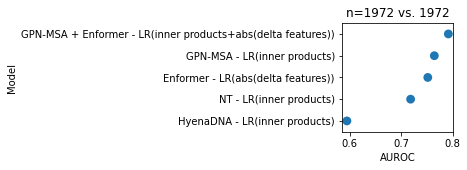

In [31]:
plt.figure(figsize=(2,2))
sns.pointplot(
    data=results[results.Model.str.contains("LR")].replace("Enformer - LR(inner products)", "Enformer - LR(abs(delta features))"),
    y="Model",
    x="AUROC",
    join=False,
)
plt.title(subtitle);
#plt.savefig("plot1.pdf", bbox_inches="tight")

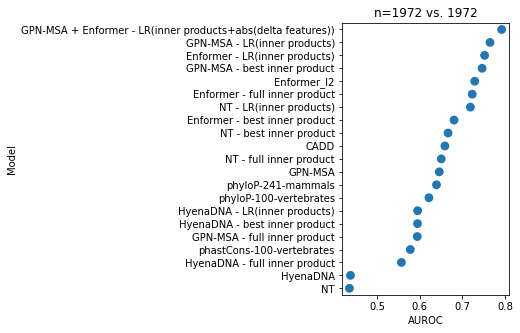

In [15]:
plt.figure(figsize=(3,5))
sns.pointplot(
    data=results,
    y="Model",
    x="AUROC",
    join=False,
)
plt.title(subtitle);

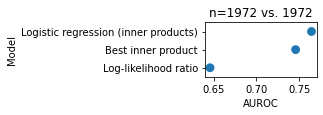

In [29]:
plt.figure(figsize=(2,1))
sns.pointplot(
    data=results[
        results.Model.str.contains("GPN-MSA") & ~results.Model.str.contains("Enformer") & ~results.Model.str.contains("full")
    ].replace({
        "GPN-MSA": "Log-likelihood ratio",
        "GPN-MSA - best inner product": "Best inner product",
        "GPN-MSA - LR(inner products)": "Logistic regression (inner products)",
    }),
    y="Model",
    x="AUROC",
    join=False,
)
plt.title(subtitle);
#plt.savefig("limitations.pdf", bbox_inches="tight")